# 数据栅格化

In [11]:
from pathlib import Path

import pandas as pd

from utils.data_io import *

In [12]:
data_path = Path("processed_ATL03_20221230185202_01561807_006_02_gt3r_cut_denoise.csv")
data = get_csv(data_path)

print(data.columns)
print("\n-------------------------\n")
# 只选择需要的列
data = data[
    [
        "Latitude (deg)",
        "Longitude (deg)",
        "UTM Easting (m)",
        "UTM Northing (m)",
        "Cross-Track (m)",
        "Along-Track (m)",
        "Height (m HAE)",
        "Height (m MSL)",
        "Solar Elevation (deg)",
        "point_type",
    ]
]

print(data.columns)

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Time (sec)', 'Delta Time (sec)',
       'Segment ID', 'GT Num', 'Beam Num', 'Beam Type', 'Latitude (deg)',
       'Longitude (deg)', 'UTM Easting (m)', 'UTM Northing (m)', 'UTM Zone',
       'UTM Hemisphere', 'Cross-Track (m)', 'Along-Track (m)',
       'Height (m HAE)', 'Height (m MSL)', 'Classification',
       'Signal Confidence', 'Solar Elevation (deg)', 'point_type', 'block'],
      dtype='object')

-------------------------

Index(['Latitude (deg)', 'Longitude (deg)', 'UTM Easting (m)',
       'UTM Northing (m)', 'Cross-Track (m)', 'Along-Track (m)',
       'Height (m HAE)', 'Height (m MSL)', 'Solar Elevation (deg)',
       'point_type'],
      dtype='object')


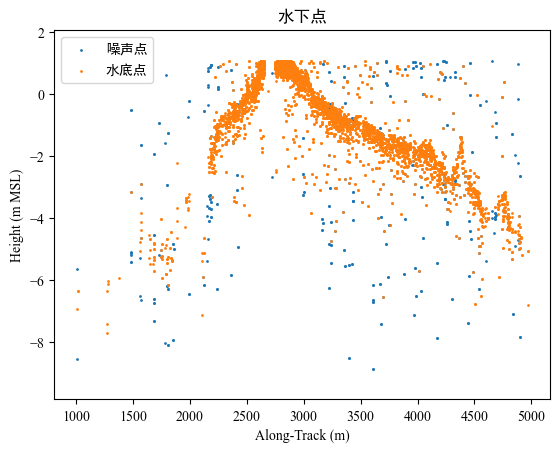

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': '水下点'}, xlabel='Along-Track (m)', ylabel='Height (m MSL)'>)

In [13]:
from utils.denoise import PointType, get_normal_distribution
from utils.plot import get_plt
from utils.property import ICESAT2Properties

under_water_point = data.loc[data["point_type"] == PointType.Valid.value]

block = {}

# unit: m
block_size = 10

for index, point in under_water_point.iterrows():
    id = point["Along-Track (m)"] // block_size
    id = int(id)
    if id not in block:
        block[id] = []
    block[id].append(point)

new_ds = []
available_keys = sorted(list(block.keys()))
for id in available_keys:
    ds = pd.DataFrame(block[id])
    if (id + 1) in available_keys:
        # 如果块是连续的则扩展窗口
        ds = pd.concat([ds, pd.DataFrame(block[id + 1])])

    ds["point_type"] = PointType.Submarine.value
    heights = ds["Height (m MSL)"].values
    mu, sigma = get_normal_distribution(heights)
    if sigma > 1:
        ds.loc[
            (ds["Height (m MSL)"] < mu - 0.5 * sigma)
            | (ds["Height (m MSL)"] > mu + 0.5 * sigma),
            "point_type",
        ] = PointType.Noise.value
    new_ds.append(ds)

seafloor_point = pd.concat(new_ds)

get_plt(seafloor_point, title="水下点")

In [14]:
blocks = []
block_min = 2

for id in block.keys():
    ds = pd.DataFrame(block[id])
    ds = seafloor_point.loc[seafloor_point["point_type"] == PointType.Submarine.value]

    # icesat-2的激光点间隔是0.7m
    # 如果block的点数小于一定值，说明这个block是无效的
    if len(ds) < block_min:
        continue
    else:
        blocks.append(id)
    
print(f"有效的block数量: {len(blocks)}")

bs = []
tmp = []
for id in blocks:
    if len(tmp) < 1:
        tmp.append(id)
        continue

    if id - tmp[-1] == 1:
        tmp.append(id)
    else:
        bs.append(tmp)
        tmp = []
        tmp.append(id)

select_ids = max(bs, key=len)
print(f"最大连续block的数量: {len(select_ids)}")
print(f"最大连续block: {select_ids[:5]}...")

有效的block数量: 287
最大连续block的数量: 119
最大连续block: [275, 276, 277, 278, 279]...


In [15]:
for idx, b in enumerate(bs):
    if idx == 0:
        continue
    if bs[idx][0] - bs[idx - 1][-1] == 2:
        if (bs[idx - 1][-1] + 1) in block.keys():
            bs[idx] = bs[idx - 1] + [bs[idx - 1][-1] + 1] + bs[idx]

select_ids = max(bs, key=len)
print(f"最大连续block的数量: {len(select_ids)}")
print(f"最大连续block: {select_ids[:5]}...")

最大连续block的数量: 119
最大连续block: [275, 276, 277, 278, 279]...


In [16]:
from utils.anti_rasterization import get_keypoint

# 复制data.columns
key_points = pd.DataFrame(columns=data.columns)
key_points_list = []
for id in select_ids:
    ds = pd.DataFrame(block[id])
    kp = get_keypoint(ds).to_frame().T
    key_points_list.append(kp)
key_points = pd.concat(key_points_list, ignore_index=True)

print(
    "key_points Along-Track (m):\n"
    + key_points["Along-Track (m)"][:3].to_string(index=False)
)
print(f"key_points数量: {len(key_points)}")

save_csv(key_points, "keypoints", tag="center", overwrite=True)

key_points Along-Track (m):
 2755.718434
 2767.936523
 2770.093916
key_points数量: 119
Overwrite operation cancelled by user.


False

len of key_points: 119


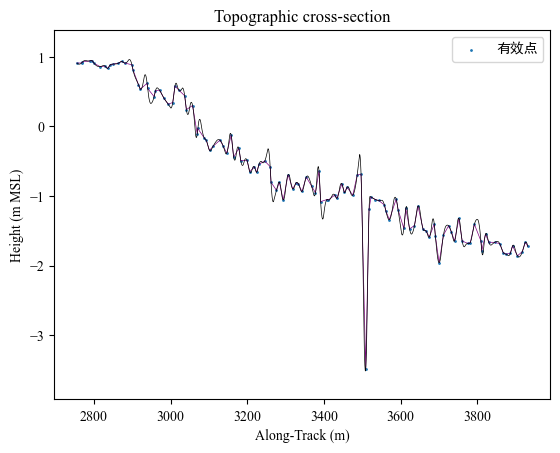

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Topographic cross-section'}, xlabel='Along-Track (m)', ylabel='Height (m MSL)'>)

In [17]:
print(f"len of key_points: {len(key_points)}")
get_plt(
    key_points,
    title="Topographic cross-section",
    curve=True,
    straight=True,
    k=2,
    bc_type="not-a-knot",
    interpolations=10000,
)